In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import datetime as datetime
import glob
import scipy
import tqdm
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.dates as mdates
#%matplotlib inline
import gsw
from subprocess import Popen, PIPE
from time import sleep
import os
from dateutil import parser

We are converting the Fortran 90 code of Bellenger's model to Python while preserving the architecture of the code so that we can tweak it once we're done. Note Fortran subroutines are similar to functions but rather than passing inputs and outputs back and forth, the subroutine has the option to modify its arguments. Whether the arguments are input-only, output-only, or inputs that can be modified before output, is set by the "intent" parameter at the beginning of the subroutine for each argument. 

In [16]:
#GLOBAL VARIABLES
cpa = 1004.67  # specific heat of dry air, in J / kg / K (Businger 1982)
cpw = 4000.    # specific heat of liquid water, in J / kg / K (DO BETTER WITH GSW?)
grav = 9.80665 # acceleration due to gravity, m s-2 (given as 9.780326772 by Bellenger, not sure why)
rhow = 1022.   # density of liquid water, in kg / m3 (DO BETTER WITH GSW?)
rgas = 287.1   # specific ideal gas constant for dry air, in J / kg / K
von = 0.4      # von Karman's "constant"
eps_w = 0.62197 # molecular mass of water over molecular mass of dry air (Gill 1982 k0829, equation 3.1.13)
beta = 0.756 / 1023.343  #Salinity expansion coefficient. Derivative with respect to practical salinity, not mass fraction of salt. Value at 25 Celsius degrees, zero pressure, practical salinity 35, from Gill (1982 k0829, table A.3.1).
depth = 3. # nominal diurnal warm layer and fresh water lens depth, in m (Zeng and Beljaars 2005)

In [148]:
# LEVEL 0 FUNCTIONS --- end of dependency tree

def esat(t, p):
    '''
    Computes saturation vapor pressure of water in Pa. From Buck, 1981, J. Appl. Meteor. 20, 1527-1532, equation (8).
    
    Inputs:
        t    - temperature [K]
        p    - air pressure [Pa]
    '''
    esat = (1.0007 + 3.46e-8 * p) * 6.1121e2 * np.exp(17.502 * (t - 273.15) / (t - 32.18))
    return esat

def therm_expans(t):
    '''
    Calculate alpha, thermal expansion coefficient for seawater. Could be replaced with the GSW toolbox function
    
    Input:
        t    - temperature [K]
    '''
    alpha = 2.1e-5 * (t - 269.95)**0.79
    return alpha

def phiw(zL):
    '''
    Calculate nondimensional temperature gradient function (wrote a better vectorized version of this below)
    
    Input:
        zL  - z over L
    '''
    if zL < 0:
        phiw = (1. - 16. * zL)**(- 0.5)
    else:
        phiw = 1. + (5. * zL + 4. * zL**2)/(1. + 3. * zL + 0.25 * zL**2) #(Takaya et al. 2010)
    
    return phiw

def fV(z, rain):
    '''
    Calculate fraction of rain volume entering the ocean and deposited within depth "z"
    Adapted from H. Bellenger 2016 Fortran code
    
    Inputs:
        z     - depth [m] (z < 0)
        rain  - rain mass flux [kg/m^2/s]
    '''
    a = 100 #coefficient of proportionality between raindrop radius and penetration depth (Manton, 1973)

    # Schlussel et al. 1997, Table 1:
    ζ = np.array([0.0026091, 0.0022743, 0.0015406, 0.0012281, 0.0008795, 0.00077123, 0.00057451, 0.000438, 6.7228e-5, 6.4955e-5, 4.4234e-5, 3.3906e-5, 2.7433e-6, 4.0283e-7])
    ψ = np.array([0.60107, 0.29968, 0.5563, 1.80858, 0.2175, 0.33961, 0.96368, 0.65081, 0.5967, 2.7661, 2.2812, 2.7674, 2.6095, 6.5308])

    if rain > 0:
        rc = 0.4 #[mm]
        z_mm = z * 1000. #[mm] and <0
        Λ = 4.1 * (rain * 3600.)**(- 0.21) # mm-1
        f0 = (1 + 2*Λ*rc + 0.5*(2*Λ*rc)**2 + (1/6)*(2*Λ*rc)**3) * np.exp(-2*Λ*rc) 
        dfv = np.sum(ζ * np.exp(-ψ*Λ*abs(z_mm)/100))
        fV = -dfv*abs(z_mm) + f0
    else:
        fV = 0
    
    return fV


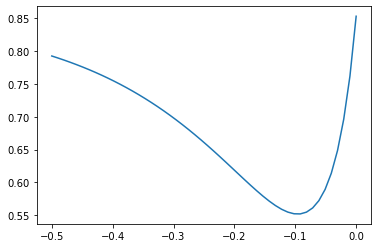

In [142]:
fVs = []
rain = 10/3600
zs = np.linspace(-0.5,0)

for z in zs:
    fVs.append(fV(z,rain))
    
plt.plot(zs,fVs)

In [137]:
ζ = np.array([0.0026091, 0.0022743, 0.0015406, 0.0012281, 0.0008795, 0.00077123, 0.00057451, 0.000438, 6.7228e-5, 6.4955e-5, 4.4234e-5, 3.3906e-5, 2.7433e-6, 4.0283e-7])
ψ = np.array([0.60107, 0.29968, 0.5563, 1.80858, 0.2175, 0.33961, 0.96368, 0.65081, 0.5967, 2.7661, 2.2812, 2.7674, 2.6095, 6.5308])

rc = 0.4 #[mm]
z_mm = -1
Λ = 4.1 * (rain * 3600.)**(- 0.21) # mm-1

dfv = np.sum(ζ * np.exp(-ψ*Λ*abs(z_mm)/100))
dfv

0.010353106758339137

In [138]:
f0 = (1 + 2*Λ*rc + 0.5*(2*Λ*rc)**2 + (1/6)*(2*Λ*rc)**3) * np.exp(-2*Λ*rc)
f0

0.8530532144729599

In [96]:
def sens_heat_rain(rain, t, q, rhoa, xlv, t_int, p):
    '''
    Computes heat flux due to rainfall, in W m-2, positive upward. From Gosnell et al., 1995 equations 11 and 12
    
    Inputs:
        rain      - rainfall in kg m-2 s-1
        t         - air temperature, in K
        q         - specific humidity, in kg/kg
        rhoa      - density of moist air  (kg / m3)
        xlv       - latent heat of evaporation (J / kg)
        t_int     - air-sea interface temperature, in K
        p         - surface pressure, in Pa
    '''

    es = esat(t_int, p) * 0.98 # saturation pressure of wator vapor, in Pa, reduced for salinity, Kraus 1972 page 46
    q_int = eps_w * (es / (p - (1. - eps_w) * es)) #specific (saturation) humidity at ocean interface
    wetc = eps_w * xlv * q_int / (rgas * t_int**2)
    dwat = 2.11e-5 * (t / 273.15)**1.94 #water vapour diffusivity
    t_celsius = t - 273.15 
    dtmp = (1. + 3.309e-3 * t_celsius - 1.44e-6 * t_celsius**2) * 0.02411 / (rhoa * cpa) #heat diffusivity

    # Gosnell 1995 k0991, equation (11):
    alfac =  1. / (1. + (wetc * xlv * dwat) / (cpa * dtmp)) # wet bulb factor

    # Gosnell 1995 k0991, equation (12):
    sens_heat_rain =  rain * alfac * cpw * (t_int - t + (q_int - q) * xlv / cpa)
    
    return sens_heat_rain


In [37]:
def mom_flux_rain(u, rain):
    '''
    Compute momentum flux due to rainfall [Pa]
    
    Inputs:
        u      - difference of velocity between air and sea, including gustiness [m/s]
        rain   - rain mass flux [kg/m^2/s]
    '''
    
    mom_flux_rain = 0.85 * u * rain   # (Caldwell 1971 k1001, equation (1) and 15 % reduction in speed as in paragraph 3.a, maybe adequate if u is the wind at 10 m)
    
    return mom_flux_rain

In [57]:
def microlayer(tkt, tks, hlb, tau, s_subskin, al, xlv, taur, rf, rain, qcol):
    '''
    Compute skin temperature and salinity given subskin values and approximate thicknesses of the layers; return skin values and revised thicknesses
    
    Inputs:
        tkt       - approximate thickness of thermal microlayer (cool skin) [m]
        tks       - approximate thickness of haline microlayer [m] 
        hlb       - latent heat flux at the surface, positive upward [W/m^2]
        tau       - wind stress, turbulent part only [Pa]
        s_subskin - subskin salinity [ppt]
        al        - thermal expansion coefficient [1/K]
        xlv       - latent heat of evaporation [J/kg]
        taur      - momentum flux due to rainfall [Pa]
        rf        - sensible heat flux at the surface due to rainfall, positive upward [W/m^2]
        rain      - rain mass flux [kg/m^2/s]
        qcol      - net flux at the surface (without sensible heat flux due to rain) [W/m^2]
    
    Outputs:
        dter      - delta temperature in diffusive thermal microlayer (air-sea interface minus subskin temperature) [C] (aka K cause it's a difference)
        dser      - delta salinity in diffusive haline microlayer (air-sea interface minus subskin salinity) [ppt]
        tkt       - revised thickness of thermal microlayer (cool skin) [m]
        tks       - revised thickness of haline microlayer [m] 
    '''

    #real, dimension(size(qcol)):: usrk, usrct, usrcs, alq
    #real xlamx(size(qcol)) ! Saunders coefficient
    
    visw = 1e-6  # viscosity of water?
    tcw = 0.6    # thermal conductivity of water
    mu = 0.0129e-7 # molecular salinity diffusivity [m^2/s], Kraus and Businger, page 47
    kappa = 1.49e-7 # thermal diffusivity [m^2/s]

    # a and b coefficients for the power function fitting the TKE flux carried by rain: Fk = a * R**b, derived from the exact solution of Soloviev and Lukas 2006 (Schlussel et al 1997, Craeye and Schlussel 1998)
    afk = 4e-4
    bfk = 1.3

    alq = al * (qcol + rf * (1 - fV(tkt, rain))) - beta * s_subskin * cpw * (hlb / xlv - rain * (1 - fV(tks, rain)))

    usrk = (afk / rhow)**(1/3) * (rain * 3600)**(bfk / 3) #Equivalent friction velocity due to the TKE input by the penetrating raindrops Fk

    # Friction velocities in the air:
    usrct = np.sqrt((tau + (1. - fV(tkt, rain)) * taur) / rhow + (fV(0., rain) - fV(tkt, rain)) * usrk**2)
    usrcs = np.sqrt((tau + (1. - fV(tks, rain)) * taur) / rhow + (fV(0., rain) - fV(tks, rain)) * usrk**2)

    if alq > 0:
        #Fairall 1996 982, equation (14):
        xlamx = 6. * (1. + (16. * grav * cpw * rhow * visw**3 * alq / (tcw**2 * usrct**4 ))**0.75)**(- 1. / 3.)

        #Fairall 1996 982, equation (12):
        tkt = xlamx * visw / usrct
        
        # From Saunders 1967 (4)
        tks = xlamx * mu * (kappa / mu)**(2. / 3.) * visw * cpw * rhow / (tcw * usrcs)
       
    else:
        xlamx = 6 # prevent excessive warm skins
        tkt = min(.01, xlamx * visw / usrct) # Limit tkt
        tks = min(.001, xlamx * mu * (kappa / mu)**(2. / 3.) * visw * cpw * rhow / (tcw * usrcs))

    # Fairall 1996 982, equation (13):
    dter = - (qcol + rf * (1 - fV(tkt, rain))) * tkt / tcw

    dser = s_subskin * (hlb / xlv - rain * (1 - fV(tks, rain))) * tks / (rhow * mu) # eq. fresh skin

    return dter, dser, tkt, tks


In [41]:
def near_surface(ds_ns, dt_ns, tau, taur, hlb, rhoa, xlv, dtime, t_ocean_1, s1, rain, q_pwp, depth_1):
    '''
    Calculate heat and freshwater budget for near-surface layer of the ocean (get subskin T & S from foundation T & S plus fluxes)
    
    Inputs:
        tau        - turbulent wind stress at the surface [Pa]
        taur       - momentum flux due to rainfall [Pa]
        hlb        - turbulent latent heat flux [W/m^2]
        rhoa       - density of moist air  [kg/m^3]
        xlv        - latent heat of evaporation [J/kg]
        dtime      - time step [s]
        t_ocean_1  - input sea temperature, at depth_1 [K]
        s1         - salinity at depth_1 [ppt]
        rain       - rain mass flux [kg/m^2/s]
        q_pwp      - net flux absorbed by the warm layer (part of the solar flux absorbed at "depth"), minus surface fluxes, in [W m^2]
        depth_1    - depth of t_ocean_1 and s1 measurements
        
    Outputs:
        al         - thermal expansion coefficient [1/K]
        ds_ns      - "delta salinity near surface" [ppt]. Salinity variation in the near-surface turbulent layer. That is subskin salinity minus foundation salinity.
        dt_ns      - "delta temperature near surface" [K aka C]. Temperature variation in the near-surface turbulent layer. That is subskin temperature minus foundation temperature.
        t_subskin  - subskin temperature, in K
        s_subskin  - subskin salinity, in ppt
    '''
    khor = 1. / 1.5e4  # Parameter for the lens spread, in m-1. Inverse of the size of the lens.
    umax = 15.
    fact = 1.

    # Temperature and salinity profiles change with wind:
    u = 28. * np.sqrt(tau / rhoa)

    # assign value for eta based on wind speed and sign of temperature gradient 
    # just using if statements for now as we're naively looping line by line
    if dt_ns < 0:
        if u >= umax:
            eta = 1. / fact
        elif u <= 2:
            eta = 2. / (fact * umax)
        else: #for 2 < u < umax
            eta = u / (fact * umax)
    else: #outside of fresh layers, leave eta constant
        eta = 0.3

    if depth_1 < depth: #if the depth of the measurements is within the nominal warm/fresh layer thickness, scale the "foundation" temperature to the assumed depth
        correction = 1. - (depth_1 / depth)**eta #(neglecting microlayer thickness compared to depth_1 and depth)
        t_fnd = t_ocean_1 - dt_ns * correction
        s_fnd = s1 - ds_ns * correction
    else: #otherwise assume well-mixed below the foundation depth
        t_fnd = t_ocean_1
        s_fnd = s1

    al = therm_expans(t_fnd)

    # Bellenger 2017 k0976, equation (13):
    buoyf = al * grav / (rhow * cpw) * q_pwp - beta * s_fnd * grav * (hlb / xlv - rain) / rhow

    usrc = np.sqrt((tau + taur) / rhow)
    drho = rhow * (- al * dt_ns + beta * ds_ns)

    # Case of stable stratification and negative flux, Bellenger 2017  k0976, equation (15):
    if buoyf < 0 and drho < 0:
        buoyf = np.sqrt(- eta * grav / (5. * depth * rhow) * drho) * usrc**2
    elif buoyf == 0:
        buoyf = np.finfo(np.float64).tiny #smallest possible non-zero positive number to avoid divide-by-zero issues

    Lmo = usrc**3 / (von * buoyf)

    # Equation (14) for temperature. Implicit scheme for time integration:
    # \Delta T_{i + 1} - \Delta T_i = \delta t (Bt + At \Delta T_{i + 1})
    At = - (eta + 1.) * von * usrc / (depth * phiw(depth / Lmo))

    # Lens horizontal spreading:
    if drho < 0 and ds_ns < 0:
        At = At - (eta + 1.) * khor * np.sqrt(depth * grav * abs(drho) / rhow)

    Bt = q_pwp / (depth * rhow * cpw * eta / (eta + 1.))
    dt_ns = (dtime * Bt + dt_ns) / (1 - dtime * At)

    # Equation (14) for salinity:
    # \frac{\partial \Delta S}{\partial t} = (\Delta S + S_\mathrm{fnd}) B_S + A_S \Delta S
    As = - (eta + 1.) * von * usrc / (depth * phiw(depth / Lmo))

    # Lens horizontal spreading:
    if drho < 0 and ds_ns < 0:
        As = As - (eta + 1.) * khor * np.sqrt(depth * grav * abs(drho) / rhow)

    Bs = (hlb / xlv - rain) * (eta + 1.) / (depth * rhow * eta)

    # Implicit scheme for time integration:
    ds_ns = (dtime * Bs * s_fnd + ds_ns) / (1 - dtime * (As + Bs))

    t_subskin = t_fnd + dt_ns
    s_subskin = s_fnd + ds_ns
    
    return al, dt_ns, ds_ns, t_subskin, s_subskin


In [11]:
def bulk_flux(u, t_ocean_1, s1, rain, hf, hlb, rnl, tau, rhoa, xlv, rf, dtime, rns, ds_ns, dt_ns, depth_1, jcool, jwarm, rain_effect):
    '''
    Bulk flux loop similar to COARE3.5 but with rain physics added
    
    Inputs:
        u           - wind speed relative to the sea surface [m/s] (i. e. taking current vector into account)
        t_ocean_1   - input sea temperature, at depth_1 [K]
        s1          - salinity at depth_1 [ppt]
        rain        - rain mass flux [kg/m^2/s]
        hf          - turbulent sensible heat flux, positive upward [W/m^2]
        hlb         - latent heat flux at the surface, positive upward [W/m^2]
        rnl         - net longwave radiation, positive upward [W/m^2]
        tau         - wind stress, turbulent part only [Pa]
        rhoa        - density of moist air  [kg/m^3]
        xlv         - latent heat of evaporation (J / kg)
        rf          - sensible heat flux at the surface due to rainfall, positive upward [W/m^2]
        dtime       - time step [s]
        rnl         - net shortwave radiation [W/m^2]
        dt_ns       - delta temperature near surface (subskin minus foundation temperature) [C] (aka K)
        ds_ns       - delta salinity near surface (subskin minus foundation salinity) [ppt]
        depth_1     - depth of bulk measurement [m]
        jcool       - boolean flag to turn on skin-layer physics
        jwarm       - boolean flag to turn on warm-layer physics
        rain_effect - boolean flag to turn on rain physics

    Outputs:
        tkt       - thickness of thermal microlayer (cool skin) [m]
        tks       - thickness of haline microlayer [m] 
        taur      - momentum flux due to rain [Pa]
        dter      - delta temperature in diffusive thermal microlayer (air-sea interface minus subskin temperature) [C] (aka K cause it's a difference)
        dser      - delta salinity in diffusive haline microlayer (air-sea interface minus subskin salinity) [ppt]
        t_int     - interface temperature, [K]
        s_int     - interface salinity [ppt]
        dt_ns     - updated delta temperature near surface (subskin minus foundation temperature) [C] (aka K cause it's a difference)
        ds_ns     - updated delta salinity near surface (subskin minus foundation salinity) [ppt]

    '''
    
    #Soloviev solar absorption profile
    fxp = 1. - (0.28 * 0.014 + 0.27 * 0.357 * (1. - np.exp(- depth / 0.357)) + .45 * 12.82 * (1.- np.exp(- depth / 12.82))) / depth
    
    tau_0 = 1e-3 # in N m-2

    #calculate rain momentum flux if rain physics are turned on, or set to zero if they're not
    if rain_effect:
        taur = mom_flux_rain(u, rain)
    else: #Bellenger had another piece of this if statement just setting up a zero value... I don't see the use: "if (jwarm .or. jcool) null_array = 0."
        taur = 0.

    tau_with_min = tau + tau_0 * (1 - np.exp(- tau_0 / tau))
    
    #-----NEAR SURFACE LAYER-----
    if jwarm:
        if rain_effect:
            q_pwp = fxp * rns - (hf + hlb + rnl + rf)
            [al, dt_ns, ds_ns, t_subskin, s_subskin] = near_surface(ds_ns, dt_ns, tau, taur, hlb, rhoa, xlv, dtime, t_ocean_1, s1, rain, q_pwp, depth_1)
        else:
            q_pwp = fxp * rns - (hf + hlb + rnl)
            [al, dt_ns, ds_ns, t_subskin, s_subskin] = near_surface(ds_ns, dt_ns, tau, taur, hlb, rhoa, xlv, dtime, t_ocean_1, s1, 0, q_pwp, depth_1)
    else:
        al = therm_expans(t_ocean_1)
        t_subskin = t_ocean_1
        s_subskin = s1
        
    #-----SKIN LAYER-----
    if jcool:
        # First guess:
        tkt = 0.001
        tks = 5e-4

        for i in np.arange(0,3): #just calls the microlayer loop three times, updating the input parameters based on the outputs
            # Cool skin
            dels = rns * (0.065 + 11. * tkt - 6.6e-5 / tkt * (1. - np.exp(- tkt / 8e-4))) # equation 16 Ohlmann
            qcol = rnl + hf + hlb - dels
            if rain_effect:
                [dter, dser, tkt, tks] = microlayer(tkt, tks, hlb, tau_with_min, s_subskin, al, xlv, taur, rf, rain, qcol)
            else:
                [dter, dser, tkt, tks] = microlayer(tkt, tks, hlb, tau_with_min, s_subskin, al, xlv, taur, 0, 0, qcol)
    else:
        tkt = 0.
        tks = 0.
        dter = 0.
        dser = 0.

    t_int = t_subskin + dter
    s_int = s_subskin + dser
    
    return tkt, tks, taur, dter, dser, t_int, s_int, ds_ns, dt_ns


In [76]:
def ocean_skin(time, u, t_ocean_1, s1, t, q, rsds, p, rain, hf, hlb, rnl, tau, depth_1, jcool, jwarm, rain_effect):
    '''
    Calculate ocean skin temperature including cool-skin, warm layer, and rain physics following Bellenger et al., 2016
    
    Inputs:
        time      - elapsed time in seconds
        u         - wind speed relative to the sea surface, i. e. taking current vector into account. In m s-1.
        t_ocean_1 - input sea temperature, at depth_1, in C
        s1        - salinity at depth_1, in ppt
        t         - air temperature, in C
        q         - specific humidity, in kg/kg
        rsds      - surface downwelling shortwave radiation, in W / m2
        p         - surface pressure, in hPa (aka mbar)
        rain      - rainfall in mm/hr
        hf        - turbulent sensible heat flux, in W m-2
        hlb       - latent heat flux at the surface (W m-2)
        rnl       - net longwave radiation, positive upward, in W m-2
        tau       - wind stress, turbulent part only, in Pa
        depth_1   - depth of bulk measurement
        jcool       - boolean flag to turn on skin-layer physics
        jwarm       - boolean flag to turn on warm-layer physics
        rain_effect - boolean flag to turn on rain physics
   
    Outputs:
        t_int     - air-sea interface temperature, in C
        s_int     - air-sea interface salinity, in ppt
        tkt       - thermal molecular diffusion microlayer (cool skin) thickness in m
        tks       - haline molecular diffusion microlayer thickness in m
        dter      - delta temperature in diffusive thermal microlayer (air-sea interface minus subskin temperature) in C
        dser      - delta salinity in diffusive haline microlayer (air-sea interface minus subskin salinity) in ppt
        dt_ns     - delta temperature near surface (subskin minus foundation temperature) in C
        ds_ns     - delta salinity near surface (subskin minus foundation salinity) in ppt
        rf        - rain sensible heat flux, in W m-2
        taur      - momentum flux due to rain, in Pa

    '''
    #----INITIAL VALUES----
    t_ocean_1 = t_ocean_1 + 273.15 # Celsius degrees to K
    t_int = t_ocean_1[0]              # initial interface temp guess by setting to input temp
    ds_ns = 0.
    dt_ns = 0.
    old_time = 0.  # in s
    
    #----CONVERSION AND SETUP---
    albedo = 0.055 # daily average
    
    t = t + 273.15 # Celsius degrees to K
    p = p * 100.   # convert hPa to Pa
    rain  = rain / 3600. # convert mm/h -> kg m-2 s-1
    rhoa = p / (rgas * t * (1. + (1. / eps_w - 1.) * q)) #calculate density of moist air (kg / m3)

    #the following is structured as a loop in fortran that goes line by line of data (long-term I would prefer to pass full arrays rather than looping)
    #initialize a bunch of empty lists to fill as we go through the loop (terrible speed-wise but I'm trying to reproduce as exactly as possible before optimizing)
    tkt_out = []
    tks_out = []
    taur_out = []
    dter_out = []
    dser_out = []
    t_int_out = []
    s_int_out = []
    ds_ns_out = []
    dt_ns_out = []
    rf_out = []
    
    for idx in tqdm.tqdm(np.arange(len(time))):
        xlv = (2.501 - 0.00237 * (t_int - 273.15)) * 1e6  #calculate latent heat of evaporation for this t_int (J / kg)
        
        rf = sens_heat_rain(rain[idx], t[idx], q[idx], rhoa[idx], xlv, t_int, p[idx]) #Gosnell 95 rain sensible heat flux

        dtime = time[idx] - old_time
        rns = (1. - albedo) * rsds[idx]
        
        #note that ds_ns and dt_ns are both inputs and outputs to this function, and will thus update every loop
        [tkt, tks, taur, dter, dser, t_int, s_int, ds_ns, dt_ns] = bulk_flux(u[idx], t_ocean_1[idx], s1[idx], rain[idx], hf[idx], hlb[idx], rnl[idx], tau[idx], rhoa[idx], xlv, rf, dtime, rns, ds_ns, dt_ns, depth_1, jcool, jwarm, rain_effect)

        tkt_out.append(tkt)
        tks_out.append(tks)
        taur_out.append(taur)
        dter_out.append(dter)
        dser_out.append(dser)
        t_int_out.append(t_int)
        s_int_out.append(s_int)
        ds_ns_out.append(ds_ns)
        dt_ns_out.append(dt_ns)
        rf_out.append(rf)

        old_time = time[idx] #update the "old_time" for the next iteration
    
    return t_int_out, s_int_out, tkt_out, tks_out, dter_out, dser_out, dt_ns_out, ds_ns_out, rf_out, taur_out


# Testing against Bellenger example dataset

In [98]:
#open Bellenger input csv
test = pd.read_csv('../Bellenger Model on Robin/ocean-skin-master/Tests/test_Hugo_B_flux_input.csv',skiprows=2,usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
test['s1'] = np.ones_like(test.time)*35
test.head()

,time,U,T_fnd,T_air,q,rsds,p,Rain,hf,hlb,rnl,tau,s1
0,0,2,26.53,23.95,0.01543,0.0,1012,8.000000e-15,8.669735,54.371128,57.381119,0.00655,35
1,1800,2,26.53,23.95,0.01543,0.0,1012,8.000000e-08,8.632769,54.243961,57.335712,0.00655,35
2,3600,2,26.53,23.95,0.01543,0.0,1012,8.000000e-03,8.589565,54.095417,57.282635,0.00654,35
3,5400,2,26.53,23.95,0.01543,0.0,1012,8.000000e+00,8.353017,53.290817,56.989632,0.00652,35
4,7200,2,26.53,23.95,0.01543,0.0,1012,8.000000e+01,8.015182,52.181629,56.549805,0.00650,35


In [99]:
[t_int, s_int, tkt, tks, dter, dser, dt_ns, ds_ns, rf, taur] = ocean_skin(test.time, test.U, test.T_fnd, test.s1, test.T_air, test.q, test.rsds, test.p, test.Rain, test.hf, test.hlb, test.rnl, test.tau, depth_1=3, jcool=True, jwarm=True, rain_effect=True)

  0%|                                                                                          | 0/144 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1870.08it/s]


In [88]:
flag3.head()

,t_int,tkt,tks,ds_ns,dt_ns,dter,rf,taur,dser,S_int
time,,,,,,,,,,
0.0,26.17398,0.001774,0.000370,0.000000,0.000000,-0.356026,3.356369e-14,3.777778e-18,0.218918,35.21892
1800.0,26.16629,0.001774,0.000370,0.000213,-0.008216,-0.355491,3.110839e-07,3.777778e-11,0.218383,35.21860
3600.0,26.15720,0.001773,0.000370,0.000428,-0.018273,-0.354529,3.105496e-02,3.777778e-06,0.196304,35.19673
5400.0,26.05948,0.001395,0.000346,-0.335710,-0.181732,-0.288787,3.099174e+01,3.777778e-03,-3.215549,31.44874
7200.0,25.73071,0.000957,0.000287,-3.186798,-0.587002,-0.212277,3.031102e+02,3.777778e-02,-7.046269,24.76693


In [90]:
#flag2 = pd.read_csv('../Bellenger Model On Robin/ocean-skin-master/Tests/test_Hugo_B_flux_output_flag2.csv',sep = '\s+', header=0,skiprows=1, index_col=0)
flag3 = pd.read_csv('../Bellenger Model On Robin/ocean-skin-master/Tests/test_Hugo_B_flux_output_flag3.csv',sep = '\s+', header=0,skiprows=1, index_col=0)

100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1617.96it/s]


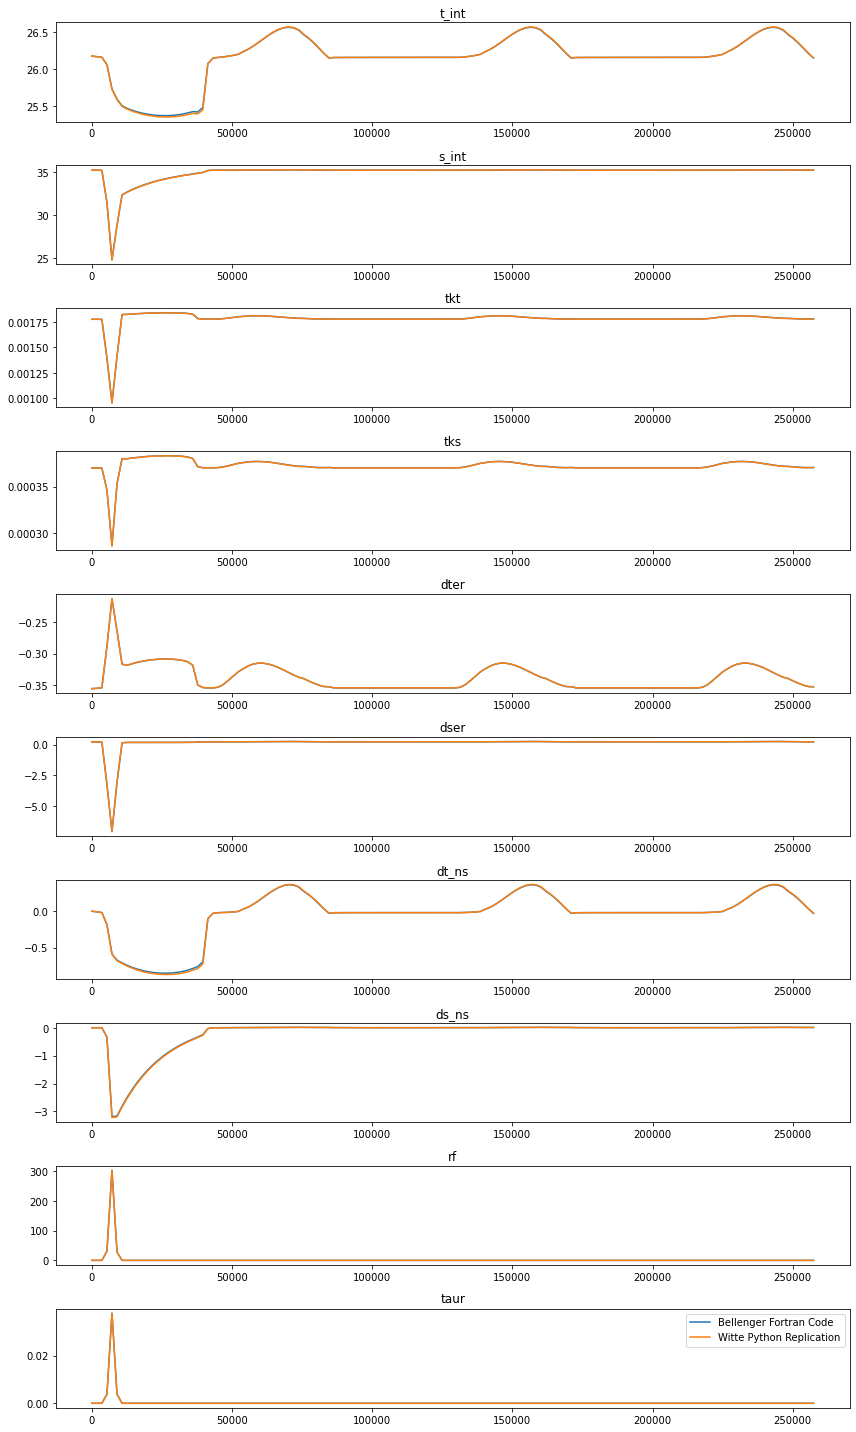

In [147]:
[t_int, s_int, tkt, tks, dter, dser, dt_ns, ds_ns, rf, taur] = ocean_skin(test.time, test.U, test.T_fnd, test.s1, test.T_air, test.q, test.rsds, test.p, test.Rain, test.hf, test.hlb, test.rnl, test.tau, depth_1=3, jcool=True, jwarm=True, rain_effect=True)

fig,axx = plt.subplots(nrows=10,figsize=(12,20))

axx[0].plot(flag3.t_int)
axx[0].plot(flag3.index, np.array(t_int) - 273.15)
axx[0].set_title('t_int')

axx[1].plot(flag3.S_int)
axx[1].plot(flag3.index, np.array(s_int))
axx[1].set_title('s_int')

axx[2].plot(flag3.tkt)
axx[2].plot(flag3.index, np.array(tkt))
axx[2].set_title('tkt')

axx[3].plot(flag3.tks)
axx[3].plot(flag3.index, np.array(tks))
axx[3].set_title('tks')

axx[4].plot(flag3.dter)
axx[4].plot(flag3.index, np.array(dter))
axx[4].set_title('dter')

axx[5].plot(flag3.dser)
axx[5].plot(flag3.index, np.array(dser))
axx[5].set_title('dser')

axx[6].plot(flag3.dt_ns)
axx[6].plot(flag3.index, np.array(dt_ns))
axx[6].set_title('dt_ns')

axx[7].plot(flag3.ds_ns)
axx[7].plot(flag3.index, np.array(ds_ns))
axx[7].set_title('ds_ns')

axx[8].plot(flag3.rf)
axx[8].plot(flag3.index, np.array(rf))
axx[8].set_title('rf')

axx[9].plot(flag3.taur)
axx[9].plot(flag3.index, np.array(taur))
axx[9].set_title('taur')

plt.legend(['Bellenger Fortran Code',
            'Witte Python Replication'])

plt.tight_layout()

In [1]:
t_int

NameError: name 't_int' is not defined

Text(0, 0.5, 'Witte Python Output')

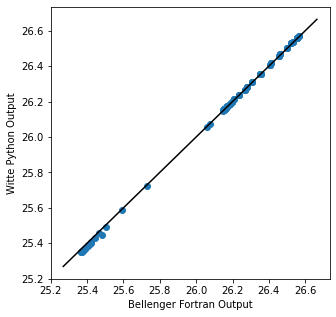

In [157]:
plt.subplots(figsize=(5,5))

space = np.linspace(flag3.t_int.min()-0.1, flag3.t_int.max()+0.1)
plt.plot(space,space,'k')
plt.scatter(flag3.t_int, np.array(t_int) - 273.15)
plt.xlabel('Bellenger Fortran Output')
plt.ylabel('Witte Python Output')

## Previously written functions

In [ ]:
def Tδ_now(Qlat, Qsens, Qlw, Qsw, Qrain, d, Td_now, Td_previous, Tδ_previous, Δt, U, ustar):
    '''
    Compute subskin temperature T_δ from finite-difference implementation of B17 eq 14
    
    Δt = length of timestep in seconds
    '''
    #constants
    κ = 0.4 #von Karman
    ρ = 1027 #kg/m^3
    c = 4000 #J/kg/K
    
    #compute solar transmission fraction at measurement depth
    fs_d = solar_transmission(d)
    
    #compute total heat flux in the layer
    Q = Qlat + Qsens + Qlw + Qrain + Qsw*fs_d
    
    #compute η assuming fresh layer
    η = η_freshlayer(U)
    
    
    
    #compute Tδ
    Tδ_now = Δt*(Q/(d*ρ*c*(η/(η+1))) - ((η+1)*κ*ustar))

In [53]:
def stability_gradient(z, L):
    '''
    Calculate nondimensional temperature gradient function following Takaya et al 2010 eq. 5 for consistency with B17.
    '''
    
    ζ = z/L
    
    ζ = np.asarray(ζ) #convert input to array for vectorization
    ϕ = np.zeros(ζ.shape) #initialize output array of same shape and all zeros
    
    #implement vectorized piecewise function
    ϕ += (ζ < 0) * (1 - 16*ζ)**(-1/2)
    ϕ = np.nan_to_num(ϕ) # that first one yields Nans and we need to make them zeroes again for this to work
    ϕ += (ζ >= 0) * (1 + ((5*ζ + 4*(ζ**2))/(1 + 3*ζ + 0.25*(ζ**2))))
    
    return ϕ


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


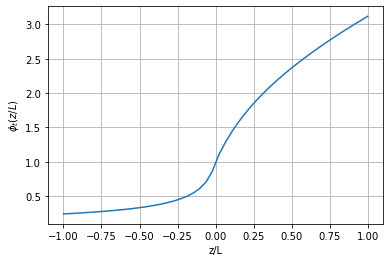

In [62]:
zs = np.linspace(-1, 1)
L = 1

plt.plot(zs/L, stability_gradient(zs,L))
plt.grid()
plt.xlabel('z/L')
plt.ylabel('$ϕ_t(z/L)$');

In [33]:
LON = 80.5
LAT = 0

def buoyancy_flux(Qlat, Qsens, Qlw, Qsw, Qrain, d, T, S, R):
    '''
    Calculate buoyancy flux following B17 eq. 13
    
    Inputs:
        Qlat - Latent Heat Flux [W/m^2]
        Qsens - Sensible Heat Flux [W/m^2]
        Qlw - Longwave Heat Flux [W/m^2]
        Qsw - Shortwave Heat Flux [W/m^2]
        Qrain - rain sensible heat flux (Gosnell) [W/m^2]
        d - measurement depth [m]
        T - temperature [C]
        S - salinity [psu]
        R - precipitation rate [mm/hr]
    
    Output:
        B - buoyancy flux [m^2/s^3]
    
    '''
    #constants
    ρ = 1027 #kg/m^3
    g = 9.8  #m/s^2
    c = 4000 #J/kg/K
    
    #thermodynamic properties
    SA = gsw.SA_from_SP(SP=S, p=0, lon=LON, lat=LAT) #g/kg
    CT = gsw.CT_from_t(SA=SA, t=T, p=0)              #C
    α = gsw.alpha(SA, CT, p=0)                       #1/K
    β = gsw.beta(SA, CT, p=0)                        #kg/g
    Lv = gsw.latentheat_evap_CT(SA, CT)              #J/kg
    
    #convert rain rate [mm/hr] to mass flux per unit area [kg/m^2/s] (1mm water = 1kg/m^2)
    P = R/3600 #kg/m^2/s
    
    #compute solar transmission fraction at measurement depth
    fs_d = solar_transmission(d)
    
    #calculate Buoyancy Flux
    B = ((α*g)/(ρ*c))*(Qlat + Qsens + Qlw + Qrain + Qsw*fs_d) - (β*g*S/ρ)*(Qlat/Lv - P)
    
    return B
    

In [41]:
def buoyancy_flux_noEquilibrium(η, d, ustar, ρ_δ, ρ_d):
    '''
    Calculate buoyancy flux following B17 eq. 15 (for cases where MO similarity theory doesn't hold because stratification is stable but buoyancy flux is negative)
    
    '''
    ρ = 1027 #kg/m^3
    
    B = (ustar**2) * (-η*g*(ρ_δ - ρ_d)/(5*d*ρ))**(1/2)
    
    return B
   

In [36]:
def η_freshlayer(U):
    '''
    Following instructions in B17 pg. 488, calculate exponent η for rain-induced fresh layers based on wind speed
    
    U - 10m wind speed (m/s)
    '''
    
    U = np.asarray(U) #convert input to array for vectorization
    η = np.zeros(U.shape) #initialize output array of same shape and all zeros
    
    #implement vectorized piecewise function
    η += (U < 2) * 0.133
    η += ((U >=2) & (U < 15))* U/15
    η += (U >= 15)* 1
    
    return η

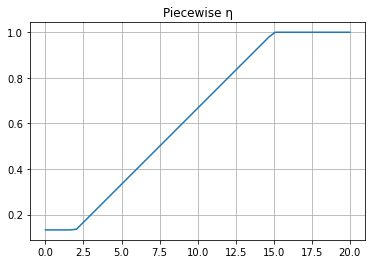

In [40]:
winds = np.linspace(0,20)
plt.plot(winds, η_freshlayer(winds))
plt.grid()
plt.title('Piecewise η');

In [5]:
def L_MO(ustar, B):
    '''
    Calculate Monin-Obukhov length L from friction velocity and buoyancy flux (B17 pg. 489)
     
    ustar = friction velocity [m/s]
    B = buoyancy flux [m^2/s^3]
    '''
    k = 0.4 #Von Karman constant
    
    L = (ustar**3)/(k*B)
    
    return L

In [186]:
def ustar_subskin(τ_wind, U, R):
    '''
    Calculate ustar in the presence of rain for sub-skin waters (neglecting turbulent effect of rain but not momentum input from rain)
    From Bellenger et al., 2017 eq. 16
     
    τ_wind = wind stress (N/m^2)
    U = 10m wind speed (m/s)
    R = rain rate (mm/hr)
    '''
    ρ = 1027 #kg/m^3
    
    τ_rain = 0.85*U*R
    
    ustar = np.sqrt((τ_wind + τ_rain)/ρ)
    
    return ustar

In [13]:
def volume_fraction_skin_B17(δ, R):
    '''
    USING 4.1 as lambda coefficient!
    Calculate the fraction of rain volume deposited in skin layer of thickness δ [m] (approximation for δ close to zero)
    From Bellenger et al., 2017 eq. 9
    '''
    a = 100 #coefficient of proportionality between raindrop radius and penetration depth (Manton, 1973)
    
    # Coefficients derived for exponential sum fit (Schlussel et al., 1997)
    ζ = [-0.26091e-2, -0.22743e-2, -0.15406e-2, -0.12281e-2, -0.87950e-3, -0.77123e-3, -0.57451e-3, -0.43800e-3, -0.67228e-4, -0.64955e-4, -0.44234e-4, -0.33906e-4, -0.27433e-5, -0.40283e-6]
    ψ = [ 0.60107,     0.29968,     0.55630,     1.80858,     0.21750,     0.33961,     0.96368,     0.65081,     0.59670,     2.7661,      2.2812,      2.7674,      2.6095,      6.5308    ]
    
    rc = 4e-4 #[m] critical radius below which raindrops lack energy needed to break surface tension (Oguz & Prosperetti, 1991)
    
    Λ = 4.1*(R**-0.21) # (Marshall and Palmer, 1948)
    
    f0 = (1 + 2*Λ*rc + 4*(Λ**2)*(rc**2) + 8*(Λ**3)*(rc**3)) * np.exp(-2*Λ*rc)
    
    sum_terms = []
    for ζi, ψi in zip(ζ,ψ):
        sum_terms.append(ζi*np.exp(-ψi*Λ*δ/a))
        
    fv = δ*np.sum(sum_terms) + f0
    
    return fv
    

In [14]:
def volume_fraction_skin_MP48(δ, R):
    '''
    USING 41 as lambda coefficient!
    Calculate the fraction of rain volume deposited in skin layer of thickness δ [m] (approximation for δ close to zero)
    From Bellenger et al., 2017 eq. 9
    '''
    a = 100 #coefficient of proportionality between raindrop radius and penetration depth (Manton, 1973)
    
    # Coefficients derived for exponential sum fit (Schlussel et al., 1997)
    ζ = [-0.26091e-2, -0.22743e-2, -0.15406e-2, -0.12281e-2, -0.87950e-3, -0.77123e-3, -0.57451e-3, -0.43800e-3, -0.67228e-4, -0.64955e-4, -0.44234e-4, -0.33906e-4, -0.27433e-5, -0.40283e-6]
    ψ = [ 0.60107,     0.29968,     0.55630,     1.80858,     0.21750,     0.33961,     0.96368,     0.65081,     0.59670,     2.7661,      2.2812,      2.7674,      2.6095,      6.5308    ]
    
    rc = 4e-4 #[m] critical radius below which raindrops lack energy needed to break surface tension (Oguz & Prosperetti, 1991)
    
    Λ = 41*(R**-0.21) # (Marshall and Palmer, 1948)
    
    f0 = (1 + 2*Λ*rc + 4*(Λ**2)*(rc**2) + 8*(Λ**3)*(rc**3)) * np.exp(-2*Λ*rc)
    
    sum_terms = []
    for ζi, ψi in zip(ζ,ψ):
        sum_terms.append(ζi*np.exp(-ψi*Λ*δ/a))
        
    fv = δ*np.sum(sum_terms) + f0
    
    return fv
    

In [247]:
fv, f0 = volume_fraction_skin(0.01,100)
fv, f0

(0.9998947207826783, 1.0000000077759559)

In [205]:
f0

1.0000012905951596

In [207]:
np.sum(sum_terms)

-0.010528667741299475

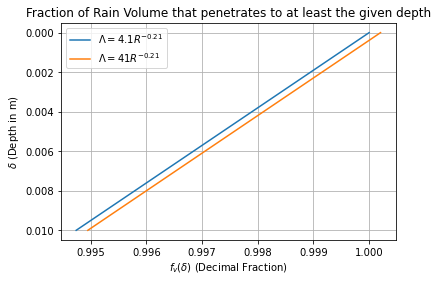

In [20]:
depths = np.linspace(0,0.01)
plt.plot(volume_fraction_skin_B17(depths,10),depths)
plt.plot(volume_fraction_skin_MP48(depths,10),depths)
plt.gca().invert_yaxis()
plt.legend(['$\Lambda = 4.1 R^{-0.21}$', '$\Lambda = 41 R^{-0.21}$'])
plt.title('Fraction of Rain Volume that penetrates to at least the given depth')#,fontsize='small')
plt.xlabel('$f_v(\delta)$ (Decimal Fraction)')
plt.ylabel('$\delta$ (Depth in m)')
plt.grid()


In [3]:
def ustar_skin(τ_wind, U, R, δ):
    '''
    Calculate ustar in the presence of rain for skin layer (including both turbulent effect of rain and momentum input from rain)
    From Bellenger et al., 2017 eq. 6
     
    τ_wind = wind stress (N/m^2)
    U = 10m wind speed (m/s)
    R = rain rate (mm/hr)
    '''
    ρ = 1027 #kg/m^3
    
    τ_rain = 0.85*U*R
    
    a = 4e-4
    b = 1.3
    τ_k = ρ*((a*(R**b))/ρ)**(2/3)
    
    fv_δ = volume_fraction_skin(δ, R)
    fv_0 = volume_fraction_skin(0, R)
    
    ustar = np.sqrt((τ_wind + (1-fv_δ)*τ_rain + (fv_0 - fv_δ)*τ_k)/ρ)
    
    return ustar

In [163]:
def solar_transmission(d):
    '''
    Given a specified depth d [m], calculate the solar transmission fraction at that depth from Fairall 1996a eq. 26 (itself taken from Soloviev 1982)
    '''
    #define constants
    F1 = 0.45
    F2 = 0.27
    F3 = 0.28
    
    γ1 = 12.8
    γ2 = 0.357
    γ3 = 0.014
    
    sum1 = F1*γ1*(1-np.exp(-d/γ1))
    sum2 = F2*γ2*(1-np.exp(-d/γ2))
    sum3 = F3*γ3*(1-np.exp(-d/γ3))
    
    fs = 1 - (sum1+sum2+sum3)/d
    
    return fs

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Depth (m)')

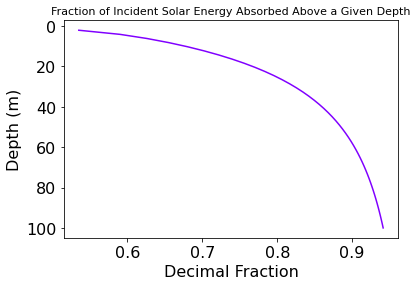

In [179]:
depths = np.linspace(0,100)
plt.plot(solar_transmission(depths),depths)
plt.gca().invert_yaxis()
plt.title('Fraction of Incident Solar Energy Absorbed Above a Given Depth',fontsize='x-small')
plt.xlabel('Decimal Fraction')
plt.ylabel('Depth (m)')

In [181]:
def solar_transmission_skin(δ):
    '''
    Given a specified skin layer thickness δ [m], calculate the fraction of solar energy absorbed in the skin layer from Zeng & Beljaars 2005 eq. 5 (aka Fairall 96a eq. 16/17)
    '''
    
    fs = 0.065 + 11*δ - (6.6e-5/δ)*(1 - np.exp(-δ/8e-4))
    
    return fs

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


Text(0, 0.5, 'Depth (m)')

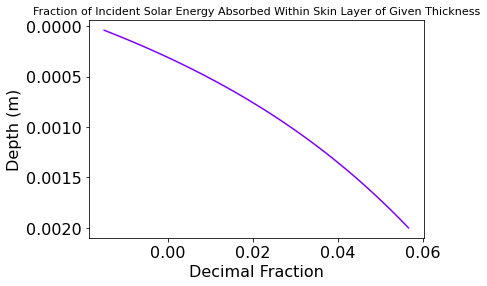

In [184]:
depths = np.linspace(0,0.002)
plt.plot(solar_transmission_skin(depths),depths)
plt.gca().invert_yaxis()
plt.title('Fraction of Incident Solar Energy Absorbed Within Skin Layer of Given Thickness',fontsize='x-small')
plt.xlabel('Decimal Fraction')
plt.ylabel('Depth (m)')